In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer


In [2]:

# load dataset
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path, header=None, names=['label', 'title', 'text'])
    test_df = pd.read_csv(test_path, header=None, names=['label', 'title', 'text'])
    return train_df, test_df

# data Overview
def dataset_overview(df, name):
    print(f"Dataset: {name}")
    print("-" * 50)
    print(df.info())
    print(df.describe(include='all'))
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())

# Class Distribution
def plot_class_distribution(df, title):
    plt.figure(figsize=(10,5))
    sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()

# text Length Analysis
def text_length_analysis(df, column):
    df['text_length'] = df[column].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10,5))
    sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of Text Length in {column}')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
    print(df['text_length'].describe())

# word Cloud
def generate_wordcloud(df, column):
    text = ' '.join(df[column].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}')
    plt.show()

# most Common Words
def most_common_words(df, column, n=20):
    text = ' '.join(df[column].astype(str).str.lower())
    words = re.findall(r'\b[a-z]{3,}\b', text)
    common_words = Counter(words).most_common(n)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top {n} Most Common Words in {column}')
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

<ipython-input-2-4fdfe4dd52b6>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path, header=None, names=['label', 'title', 'text'])


Dataset: Train Set
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560001 entries, 0 to 560000
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   560001 non-null  object
 1   title   560001 non-null  object
 2   text    560001 non-null  object
dtypes: object(3)
memory usage: 12.8+ MB
None
         label                     title  \
count   560001                    560001   
unique      16                    560001   
top          0  The Vinyl Cafe Notebooks   
freq     40000                         1   

                                                     text  
count                                              560001  
unique                                             559880  
top      Tom Clancy's Net Force Explorers or Net Force...  
freq                                                   15  

Missing values:
label    0
title    0
text     0
dtype: int64

Dupl

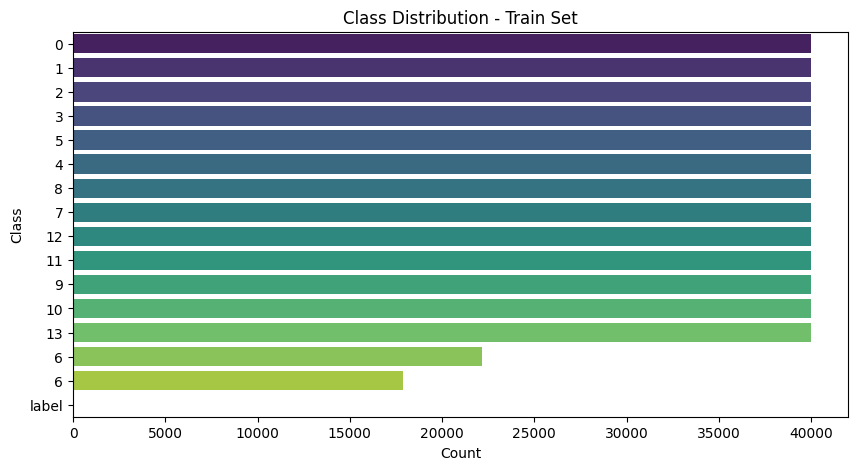

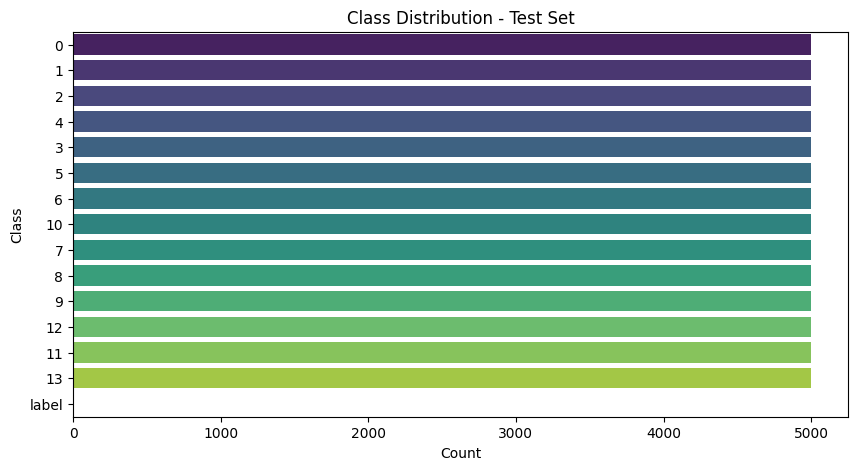

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


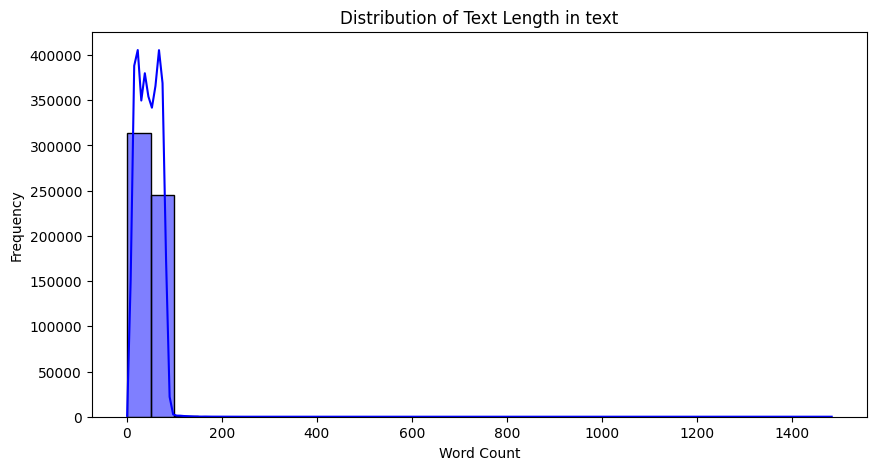

count    560001.000000
mean         46.133153
std          22.469242
min           1.000000
25%          27.000000
50%          46.000000
75%          65.000000
max        1484.000000
Name: text_length, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


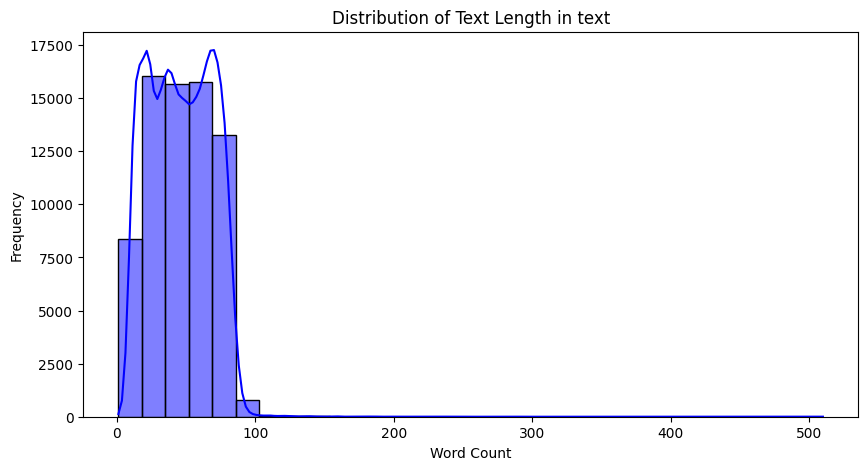

count    70001.000000
mean        46.140812
std         22.364355
min          1.000000
25%         27.000000
50%         46.000000
75%         65.000000
max        510.000000
Name: text_length, dtype: float64


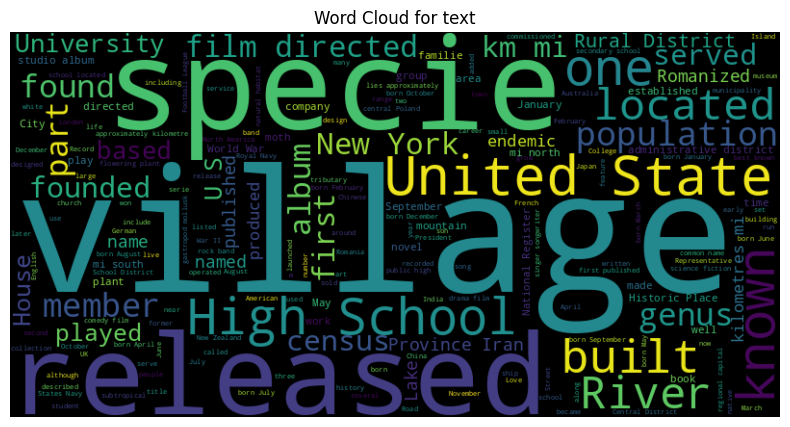

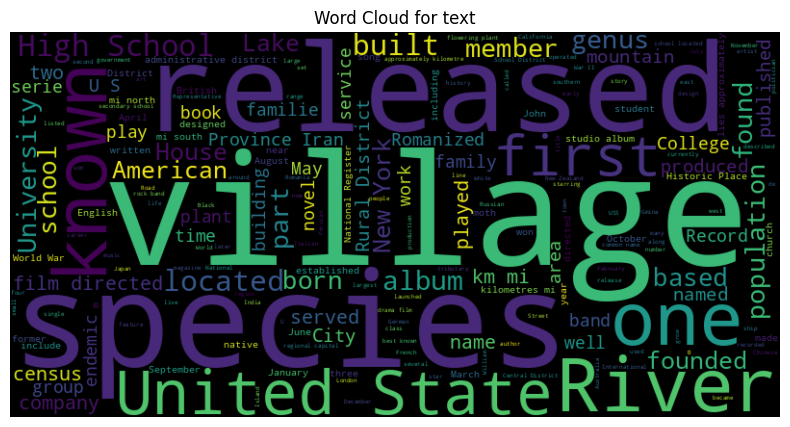

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


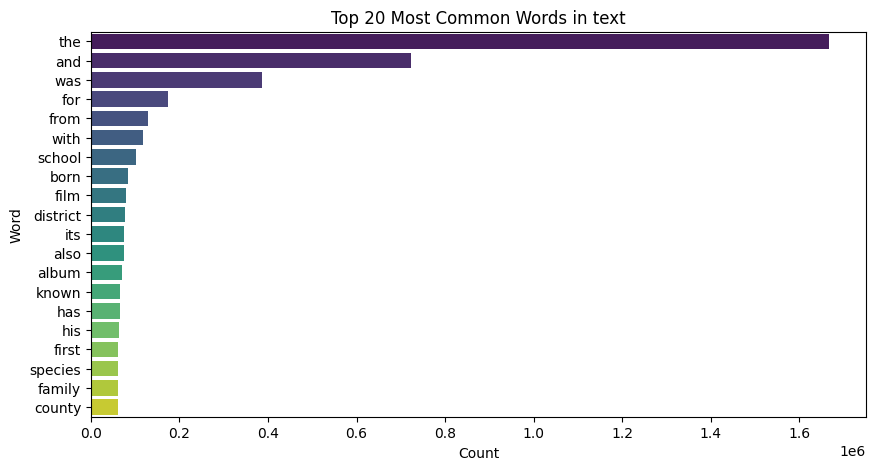

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


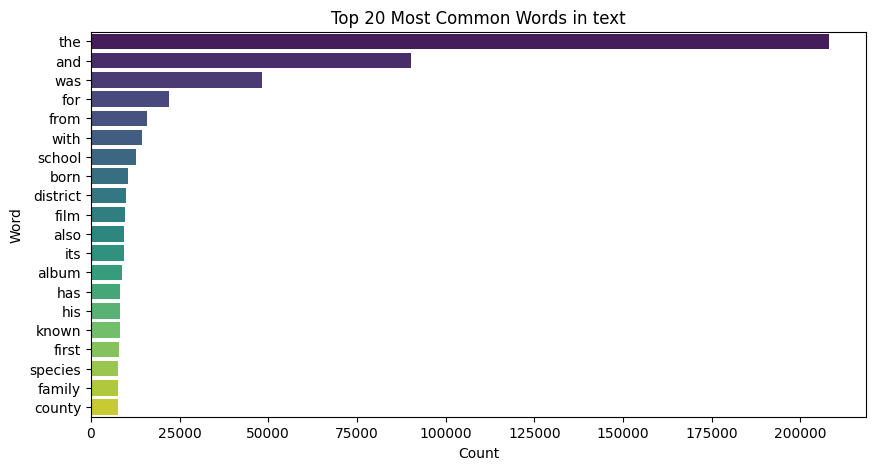

In [3]:

train_path = '/kaggle/input/dbpedia-ontology/train.csv'
test_path = '/kaggle/input/dbpedia-ontology/test.csv'

train_df, test_df = load_data(train_path, test_path)

dataset_overview(train_df, 'Train Set')
dataset_overview(test_df, 'Test Set')

plot_class_distribution(train_df, 'Train Set')
plot_class_distribution(test_df, 'Test Set')

text_length_analysis(train_df, 'text')
text_length_analysis(test_df, 'text')

generate_wordcloud(train_df, 'text')
generate_wordcloud(test_df, 'text')

most_common_words(train_df, 'text')
most_common_words(test_df, 'text')


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        text_column = 'content' if 'content' in df.columns else 'title'  # Use 'content', fallback to 'title'

        self.texts = df[text_column].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class EPASSModel(nn.Module):
    def __init__(self, base_model, num_classes, projector_dim=128, num_projectors=3):
        super(EPASSModel, self).__init__()
        self.encoder = base_model  # Pretrained BERT
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(768, projector_dim),
                nn.ReLU(),
                nn.Linear(projector_dim, num_classes)
            ) for _ in range(num_projectors)
        ])

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            features = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        projections = torch.stack([proj(features) for proj in self.projectors], dim=0)
        ensemble_output = torch.mean(projections, dim=0)  # Average the projections
        return ensemble_output

def train_model(model, dataloader, optimizer, criterion, device, epochs=3):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss {total_loss/len(dataloader):.4f}")

    return "EPASS Training Completed"

def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

train_path = '/kaggle/input/dbpedia-ontology/train.csv'
test_path = '/kaggle/input/dbpedia-ontology/test.csv'

train_df, test_df = load_data(train_path, test_path)

batch_size = 16
train_dataset = TextDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EPASSModel(bert_model, num_classes=len(train_df['label'].unique()))
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

epass_results = train_model(model, train_loader, optimizer, criterion, device, epochs=3)
print(epass_results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Loss 0.0892
Epoch 2: Loss 0.0464
Epoch 3: Loss 0.0427
EPASS Training Completed


In [5]:
torch.save(model, "/kaggle/working/epass_model_full.pth")


In [6]:
test_dataset = TextDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
def evaluate_model(model, dataloader, device):
    model.eval()  
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            
            _, predicted = torch.max(outputs, dim=1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    return accuracy
accuracy = evaluate_model(model, test_loader, device)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.9904285714285714


In [7]:
accuracy_percent = accuracy * 100
print(f"Test Accuracy: {accuracy_percent:.2f}%")


Test Accuracy: 99.04%
